<a href="https://colab.research.google.com/github/denysmatyushyn/overnight/blob/main/ETH_PPO_ticks_Core.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import asyncio
import nest_asyncio
import websockets
import json
import numpy as np
import pandas as pd
from datetime import datetime, timezone
from collections import deque

from gymnasium import Env, spaces
!pip install stable-baselines3
from stable_baselines3 import PPO

import matplotlib.pyplot as plt

# Настройки Binance
symbol = 'ETHUSDT'
symbol_ws = 'ethusdt'

# Обновлённый список признаков
features = [
    'log_return',
    'price_deviation',
    'volatility',
    'rolling_volume',
    'is_buy',
    'spread_to_ema',
    'delta_volume',
    'price_momentum'
]

window = 10
buffer = deque(maxlen=window + 1)
position = None
entry_price = 0.0
last_quantity = 0.0

In [ ]:
def preprocess(df):
    df['price_shift'] = df['price'].shift(1)
    df['log_return'] = np.log(df['price'] / df['price_shift'])
    df['rolling_mean'] = df['price'].rolling(window=window, min_periods=1).mean()
    df['price_deviation'] = (df['price'] - df['rolling_mean']) / df['rolling_mean']
    df['rolling_std'] = df['log_return'].rolling(window=window, min_periods=1).std().fillna(0)
    df['volatility'] = df['rolling_std']
    df['rolling_volume'] = df['amount'].rolling(window=window, min_periods=1).mean().fillna(0)
    df['is_buy'] = (df['side'] == 'buy').astype(int)
    df['ema_10'] = df['price'].ewm(span=10).mean()
    df['spread_to_ema'] = (df['price'] - df['ema_10']) / df['ema_10']
    df['delta_volume'] = df['is_buy'].rolling(window=window).sum() - (1 - df['is_buy']).rolling(window=window).sum()
    df['price_momentum'] = df['price'] - df['price'].shift(window)

    df = df.dropna().reset_index(drop=True)
    return df


class QuickTradingEnv(Env):
    def __init__(self, df_state, full_df, fee=0.0):
        super().__init__()
        self.df = df_state.reset_index(drop=True)
        self.time_series = full_df['datetime'].reset_index(drop=True)
        self.price_series = full_df['price'].reset_index(drop=True)
        self.volatility_series = full_df['volatility'].reset_index(drop=True)
        self.fee = fee
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(self.df.shape[1] + 1,),
            dtype=np.float32
        )
        self.reset()

    def reset(self, seed=None, options=None):
        self.step_idx = 0
        self.position = 0
        self.entry_price = 0
        self.entry_time = None
        self.total_reward = 0
        self.logs = []
        return self._get_obs(), {}

    def _get_obs(self):
        obs = self.df.iloc[self.step_idx].values.astype(np.float32)
        return np.append(obs, self.position)

    def step(self, action):
        price = self.price_series[self.step_idx]
        current_time = self.time_series[self.step_idx]
        vol = self.volatility_series[self.step_idx]
        reward = 0
        pnl = 0
        event = "HOLD"

        # ⛔ Мягкий фильтр по волатильности
        if vol < 0.0002:
            action = 0

        # 🔻 Уменьшенный штраф за HOLD без позиции
        if self.position == 0 and action == 0:
            reward -= 0.002

        # ✅ Повышенный бонус за открытие позиции
        if action in [1, 2] and self.position == 0:
            reward += 0.005

        # 🔻 Меньший штраф за удержание позиции
        if self.position != 0:
            reward -= 0.0002

        # === Открытие LONG ===
        if action == 1 and self.position == 0:
            self.position = 1
            self.entry_price = price
            self.entry_time = current_time
            event = "OPEN_LONG"

        # === Открытие SHORT ===
        elif action == 2 and self.position == 0:
            self.position = -1
            self.entry_price = price
            self.entry_time = current_time
            event = "OPEN_SHORT"

        # === Закрытие LONG ===
        elif self.position == 1:
            pnl_pct = (price - self.entry_price) / self.entry_price
            time_in_position = (current_time - self.entry_time).total_seconds() / 60
            if action == 2:
                event = "CLOSE_LONG"

                if pnl_pct > 2 * self.fee:
                    reward += (pnl_pct - 2 * self.fee)
                else:
                    reward -= 0.001

                self.position = 0
                self.entry_price = 0
                self.entry_time = None

        # === Закрытие SHORT ===
        elif self.position == -1:
            pnl_pct = (self.entry_price - price) / self.entry_price
            time_in_position = (current_time - self.entry_time).total_seconds() / 60
            if action == 1:
                event = "CLOSE_SHORT"

                if pnl_pct > 2 * self.fee:
                    reward += (pnl_pct - 2 * self.fee)
                else:
                    reward -= 0.001

                self.position = 0
                self.entry_price = 0
                self.entry_time = None

        self.logs.append({
            "step_idx": self.step_idx,
            "action": action,
            "price": price,
            "position": self.position,
            "event": event,
            "reward": reward,
            "pnl": pnl_pct if 'pnl_pct' in locals() else 0.0
        })

        self.step_idx += 1
        done = self.step_idx >= len(self.df) - 1
        self.total_reward += reward
        return self._get_obs(), reward, done, False, {"total_profit": self.total_reward}



In [ ]:
df_train = pd.read_csv("ETH_USDT_20250506.csv", parse_dates=['datetime'])
df_train = preprocess(df_train)
df_state_train = df_train[features]

env = QuickTradingEnv(df_state_train, df_train, fee=0.00045)
model = PPO(
    "MlpPolicy",
    env,
    learning_rate=3e-5,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.005,
    vf_coef=0.5,
    max_grad_norm=0.5,
    verbose=1
)
model.learn(total_timesteps=50000)
print("✅ Модель обучена и готова к торговле")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 652  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 621          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0024803467 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | 0.0137       |
|    learning_rate        | 3e-05        |
|    loss                 | 0.0186       |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00125     |
|    val

In [ ]:
def plot_equity_curve(trades):
    # Копируем и накапливаем net_pnl
    trades = trades.copy()
    trades['equity'] = trades['net_pnl'].cumsum()

    # Построение графика
    plt.figure(figsize=(12, 6))
    plt.plot(trades['exit_step'], trades['equity'], linewidth=2)
    plt.title("График доходности (Equity Curve)")
    plt.xlabel("Шаг выхода из сделки")
    plt.ylabel("Накопленная прибыль")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def analyze_trades(logs, fee=0.0004, quantity=1):  # ← укажи свой объём
    trades = []
    position = 0
    entry_price = None
    entry_step = None

    for row in logs:
        action = row['action']
        price = row['price']
        step = row['step_idx']
        event = row['event']

        if event == 'OPEN_LONG':
            position = 1
            entry_price = price
            entry_step = step

        elif event == 'OPEN_SHORT':
            position = -1
            entry_price = price
            entry_step = step

        elif event == 'CLOSE_LONG' and position == 1:
            pnl = (price - entry_price) * quantity
            fee_cost = (entry_price + price) * quantity * fee
            trades.append({
                'entry_step': entry_step,
                'exit_step': step,
                'duration': step - entry_step,
                'direction': 'LONG',
                'entry_price': entry_price,
                'exit_price': price,
                'pnl': pnl,
                'fee_cost': fee_cost,
                'net_pnl': pnl - fee_cost
            })
            position = 0
            entry_price = None

        elif event == 'CLOSE_SHORT' and position == -1:
            pnl = (entry_price - price) * quantity
            fee_cost = (entry_price + price) * quantity * fee
            trades.append({
                'entry_step': entry_step,
                'exit_step': step,
                'duration': step - entry_step,
                'direction': 'SHORT',
                'entry_price': entry_price,
                'exit_price': price,
                'pnl': pnl,
                'fee_cost': fee_cost,
                'net_pnl': pnl - fee_cost
            })
            position = 0
            entry_price = None

    return pd.DataFrame(trades)

def run_backtest(model, csv_path, fee=0.0004):
    # Загрузка и подготовка данных
    df_test = pd.read_csv(csv_path, parse_dates=['datetime'])
    df_test = preprocess(df_test)
    df_state_test = df_test[features]

    # Окружение
    env = QuickTradingEnv(df_state_test, df_test, fee=fee)
    obs, _ = env.reset()
    done = False

    # Прогон модели
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)

    # Анализ логов
    trades = analyze_trades(env.logs, fee=fee)

    if trades.empty:
        print("\n⚠️ Нет совершённых сделок.")
        return  # можно return, или return trades, если надо

    # 📈 Все сделки
    print("\n📈 Совершённые сделки:")
    print(trades[['entry_step', 'exit_step', 'direction', 'entry_price', 'exit_price', 'pnl', 'net_pnl']].head(20))

    # 📊 Статистика
    total_trades = len(trades)
    total_pnl = trades['pnl'].sum()
    total_net_pnl = trades['net_pnl'].sum()

    win_trades = trades[trades['pnl'] > 0]
    loss_trades = trades[trades['pnl'] <= 0]
    winrate = len(win_trades) / total_trades * 100 if total_trades else 0

    avg_win = win_trades['net_pnl'].mean() if not win_trades.empty else 0
    avg_loss = loss_trades['net_pnl'].mean() if not loss_trades.empty else 0

    print("\n📊 Статистика:")
    print(f"🔁 Кол-во сделок: {total_trades}")
    print(f"💰 Общий PnL (до комиссии): {total_pnl:.4f}")
    print(f"💸 Чистая прибыль (после комиссии): {total_net_pnl:.4f}")
    print(f"✅ Прибыльных сделок: {len(win_trades)}")
    print(f"❌ Убыточных сделок: {len(loss_trades)}")
    print(f"📈 Winrate: {winrate:.2f}%")
    print(f"📊 Средняя прибыльная сделка: {avg_win:.4f}")
    print(f"📉 Средняя убыточная сделка: {avg_loss:.4f}")
    avg_duration = trades['duration'].mean()
    avg_win_duration = win_trades['duration'].mean() if not win_trades.empty else 0
    avg_loss_duration = loss_trades['duration'].mean() if not loss_trades.empty else 0

    print(f"⏱ Средняя длительность сделки (в шагах): {avg_duration:.2f}")
    print(f"⏱ Средняя длительность прибыльной сделки: {avg_win_duration:.2f}")
    print(f"⏱ Средняя длительность убыточной сделки: {avg_loss_duration:.2f}")

    # ❌ Убыточные сделки
    print("\n❌ Убыточные сделки:")
    print(loss_trades[['entry_step', 'exit_step', 'direction', 'pnl', 'net_pnl']].head(10))

    # 📈 График
    plot_equity_curve(trades)


📈 Совершённые сделки:
   entry_step  exit_step direction  entry_price  exit_price    pnl    net_pnl
0       17553      17573      LONG      1832.26     1832.70   0.44  -1.025984
1       17574      18501     SHORT      1832.71     1831.43   1.28  -0.185656
2       18502      44384      LONG      1831.44     1836.60   5.16   3.692784
3       44385     118721     SHORT      1836.35     1826.41   9.94   8.474896
4      118722     142790      LONG      1826.34     1821.83  -4.51  -5.969268
5      142791     350714     SHORT      1821.81     1827.37  -5.56  -7.019672
6      350715     509047      LONG      1827.37     1799.00 -28.37 -29.820548
7      509048     526520     SHORT      1799.00     1802.93  -3.93  -5.370772
8      526521     527154      LONG      1802.98     1805.87   2.89   1.446460
9      527155     716238     SHORT      1805.83     1813.08  -7.25  -8.697564

📊 Статистика:
🔁 Кол-во сделок: 10
💰 Общий PnL (до комиссии): -29.9100
💸 Чистая прибыль (после комиссии): -44.4753
✅ Пр

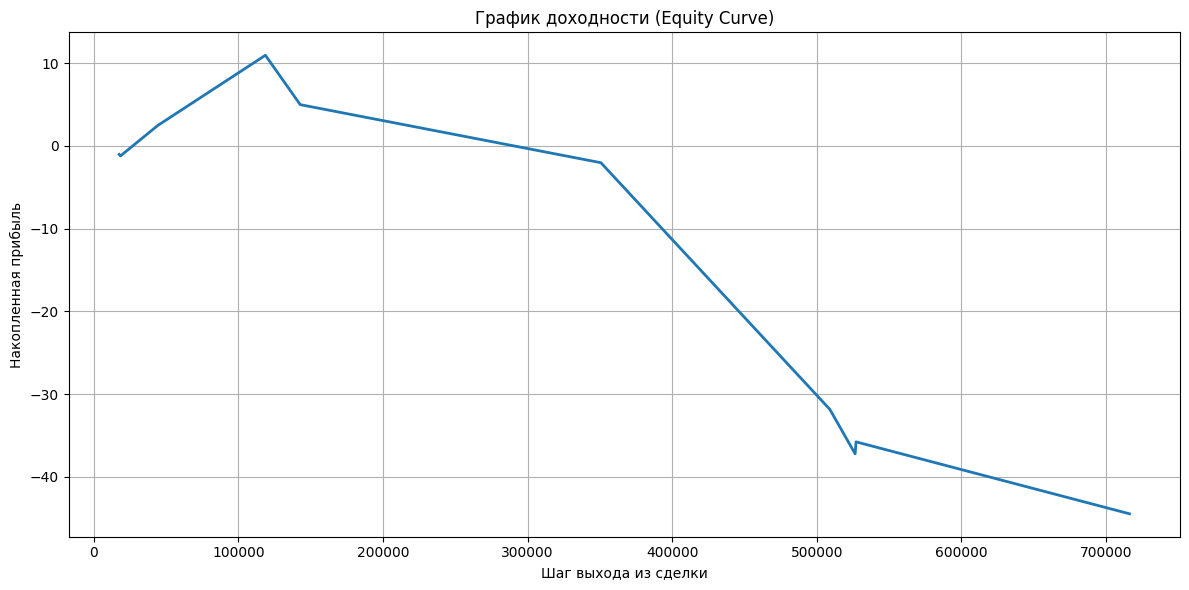

In [ ]:
run_backtest(model, "ETH_USDT_20250507.csv")

In [ ]:
def analyze_trades(logs, fee_fixed=0.04, quantity=0.011):
    trades = []
    position = 0
    entry_price = None
    entry_step = None

    for row in logs:
        action = row['action']
        price = row['price']
        step = row['step_idx']
        event = row['event']

        if event == 'OPEN_LONG':
            position = 1
            entry_price = price
            entry_step = step

        elif event == 'OPEN_SHORT':
            position = -1
            entry_price = price
            entry_step = step

        elif event == 'CLOSE_LONG' and position == 1:
            avg_price = (entry_price + price) / 2
            pnl = (price - entry_price) * quantity * avg_price
            fee_cost = fee_fixed * 2
            trades.append({
                'entry_step': entry_step,
                'exit_step': step,
                'duration': step - entry_step,
                'direction': 'LONG',
                'entry_price': entry_price,
                'exit_price': price,
                'pnl': round(pnl, 2),
                'net_pnl': round(pnl - fee_cost, 2)
            })
            position = 0
            entry_price = None

        elif event == 'CLOSE_SHORT' and position == -1:
            avg_price = (entry_price + price) / 2
            pnl = (entry_price - price) * quantity * avg_price
            fee_cost = fee_fixed * 2
            trades.append({
                'entry_step': entry_step,
                'exit_step': step,
                'duration': step - entry_step,
                'direction': 'SHORT',
                'entry_price': entry_price,
                'exit_price': price,
                'pnl': round(pnl, 2),
                'net_pnl': round(pnl - fee_cost, 2)
            })
            position = 0
            entry_price = None

    return pd.DataFrame(trades)

def run_backtest(model, csv_path, fee=0.04):
    # Загрузка и подготовка данных
    df_test = pd.read_csv(csv_path, parse_dates=['datetime'])
    df_test = preprocess(df_test)
    df_state_test = df_test[features]

    # Окружение
    env = QuickTradingEnv(df_state_test, df_test, fee=fee)
    obs, _ = env.reset()
    done = False

    # Прогон модели
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)

    # Анализ логов
    trades = analyze_trades(env.logs, fee_fixed=0.04)

    if trades.empty:
        print("\n⚠️ Нет совершённых сделок.")
        return  # можно return, или return trades, если надо

    # 📈 Все сделки
    print("\n📈 Совершённые сделки:")
    print(trades[['entry_step', 'exit_step', 'direction', 'entry_price', 'exit_price', 'pnl', 'net_pnl']].head(20))

    # 📊 Статистика
    total_trades = len(trades)
    total_pnl = trades['pnl'].sum()
    total_net_pnl = trades['net_pnl'].sum()

    win_trades = trades[trades['pnl'] > 0]
    loss_trades = trades[trades['pnl'] <= 0]
    winrate = len(win_trades) / total_trades * 100 if total_trades else 0

    avg_win = win_trades['net_pnl'].mean() if not win_trades.empty else 0
    avg_loss = loss_trades['net_pnl'].mean() if not loss_trades.empty else 0

    print("\n📊 Статистика:")
    print(f"🔁 Кол-во сделок: {total_trades}")
    print(f"💰 Общий PnL (до комиссии): {total_pnl:.4f}")
    print(f"💸 Чистая прибыль (после комиссии): {total_net_pnl:.4f}")
    print(f"✅ Прибыльных сделок: {len(win_trades)}")
    print(f"❌ Убыточных сделок: {len(loss_trades)}")
    print(f"📈 Winrate: {winrate:.2f}%")
    print(f"📊 Средняя прибыльная сделка: {avg_win:.4f}")
    print(f"📉 Средняя убыточная сделка: {avg_loss:.4f}")
    avg_duration = trades['duration'].mean()
    avg_win_duration = win_trades['duration'].mean() if not win_trades.empty else 0
    avg_loss_duration = loss_trades['duration'].mean() if not loss_trades.empty else 0

    print(f"⏱ Средняя длительность сделки (в шагах): {avg_duration:.2f}")
    print(f"⏱ Средняя длительность прибыльной сделки: {avg_win_duration:.2f}")
    print(f"⏱ Средняя длительность убыточной сделки: {avg_loss_duration:.2f}")

    # ❌ Убыточные сделки
    print("\n❌ Убыточные сделки:")
    print(loss_trades[['entry_step', 'exit_step', 'direction', 'pnl', 'net_pnl']].head(10))

    # 📈 График
    plot_equity_curve(trades)


📈 Совершённые сделки:
   entry_step  exit_step direction  entry_price  exit_price     pnl  net_pnl
0       17553      17573      LONG      1832.26     1832.70    8.87     8.79
1       17574      18501     SHORT      1832.71     1831.43   25.80    25.72
2       18502      44384      LONG      1831.44     1836.60  104.10   104.02
3       44385     118721     SHORT      1836.35     1826.41  200.24   200.16
4      118722     142790      LONG      1826.34     1821.83  -90.49   -90.57
5      142791     350714     SHORT      1821.81     1827.37 -111.59  -111.67
6      350715     509047      LONG      1827.37     1799.00 -565.84  -565.92
7      509048     526520     SHORT      1799.00     1802.93  -77.86   -77.94
8      526521     527154      LONG      1802.98     1805.87   57.36    57.28
9      527155     716238     SHORT      1805.83     1813.08 -144.30  -144.38

📊 Статистика:
🔁 Кол-во сделок: 10
💰 Общий PnL (до комиссии): -593.7100
💸 Чистая прибыль (после комиссии): -594.5100
✅ Прибыльных 

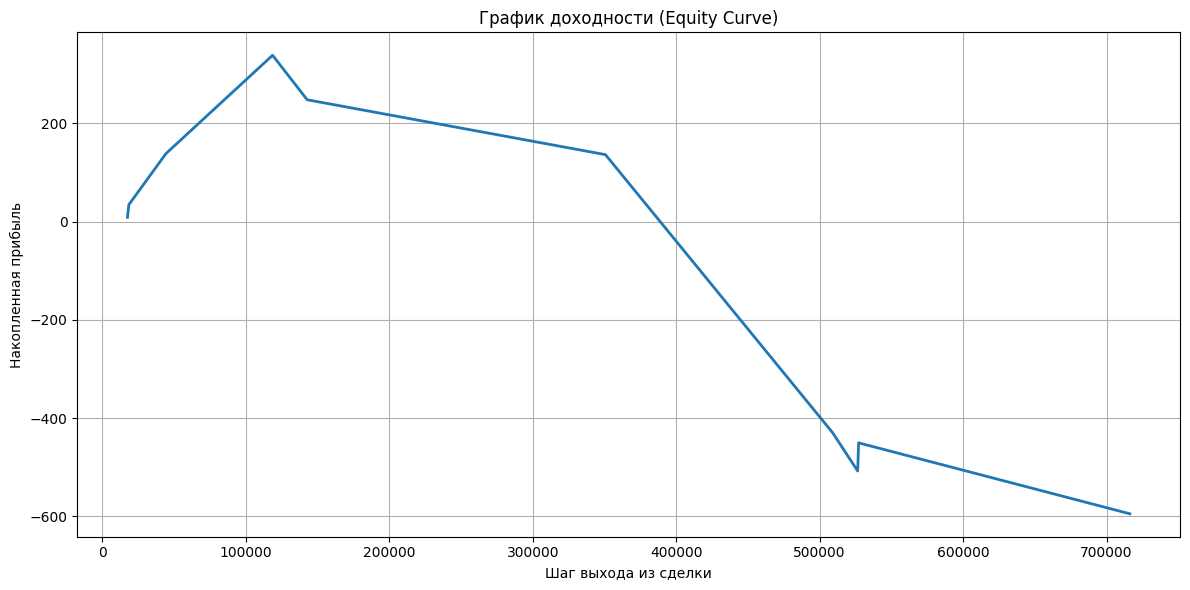

In [ ]:
run_backtest(model, "ETH_USDT_20250507.csv")


📈 Совершённые сделки:
    entry_step  exit_step direction  entry_price  exit_price      pnl  net_pnl
0       122287     133225     SHORT      1843.55     1847.33   -76.73   -76.81
1       133226     230994      LONG      1847.33     1897.96  1042.93  1042.85
2       230995     243296     SHORT      1897.96     1901.37   -71.26   -71.34
3       243297     252299      LONG      1902.07     1914.88   268.92   268.84
4       252300     254532     SHORT      1914.88     1913.70    24.85    24.77
5       254533     274655      LONG      1913.70     1911.87   -38.50   -38.58
6       274656     340410     SHORT      1911.88     1903.69   171.87   171.79
7       340411     355432      LONG      1903.17     1900.01   -66.10   -66.18
8       355433     419402     SHORT      1899.50     1921.48  -461.92  -462.00
9       419403     420080      LONG      1921.48     1924.57    65.36    65.28
10      420081     420105     SHORT      1924.57     1925.19   -13.13   -13.21
11      420106     420107    

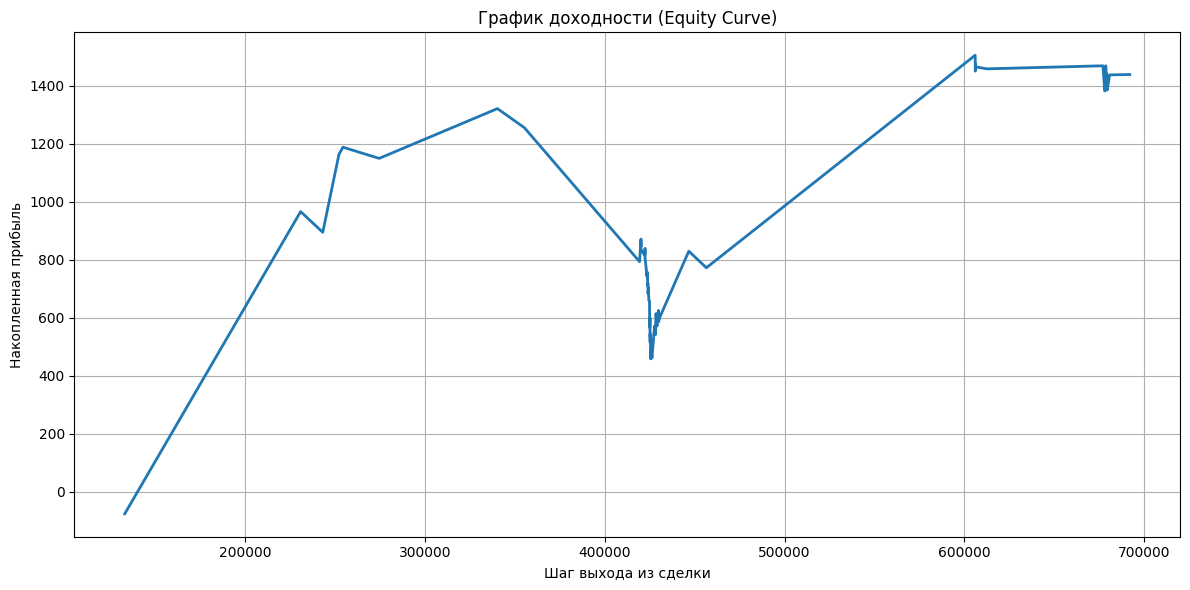

In [ ]:
run_backtest(model, "ETH_USDT_20250508.csv")

In [ ]:
model.save("ppo_eth_trading_model")
print("💾 Модель сохранена: ppo_eth_trading_model.zip")

💾 Модель сохранена: ppo_eth_trading_model.zip
